In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import unicodedata
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import prep
import acquire

## Sentiment analysis of books of different religious texts

An overview using natural language processing and vader sentiment analysis to look at what percent of verses are very positive, positive, neutral, negative, and very negative.

### Bible

In [2]:
df = acquire.bible_wrangle()

In [3]:
df.head(2)

,id,book_no,ch,ver,text,book,test,genre_no,genre
0,1001001,1,1,1,In the beginning God created the heavens and t...,Genesis,OT,1,Law
1,1001002,1,1,2,And the earth was waste and void; and darkness...,Genesis,OT,1,Law


In [4]:
#removing stopwords, lower casing, and tokenizing each verse.
df.text = df.text.apply(prep.basic_clean)
df.text = df.text.apply(prep.remove_stopwords)

In [5]:
# creating column for each verse stemmed.
df['stemmed'] = df.text.apply(prep.stem)

In [6]:
df.head(2)

,id,book_no,ch,ver,text,book,test,genre_no,genre,stemmed
0,1001001,1,1,1,beginning god created heavens earth,Genesis,OT,1,Law,begin god creat heaven earth
1,1001002,1,1,2,earth waste void darkness upon face deep spiri...,Genesis,OT,1,Law,earth wast void dark upon face deep spirit god...


In [7]:
# Sentiment intensity algorithm initialized
sia = SentimentIntensityAnalyzer()

In [8]:
# Example of how SIA scores a corpus.
blob = "For God so loved the world that he gave his only son to die for us"
sia.polarity_scores(blob)

{'neg': 0.163, 'neu': 0.542, 'pos': 0.296, 'compound': 0.4924}

In [9]:
df.head(2)

,id,book_no,ch,ver,text,book,test,genre_no,genre,stemmed
0,1001001,1,1,1,beginning god created heavens earth,Genesis,OT,1,Law,begin god creat heaven earth
1,1001002,1,1,2,earth waste void darkness upon face deep spiri...,Genesis,OT,1,Law,earth wast void dark upon face deep spirit god...


In [10]:
df['vader_sentiment'] = df.text.apply(lambda txt: sia.polarity_scores(txt)['compound'])

In [11]:
print("Sentiment of each group of books by genre")
df.groupby('genre')['genre','vader_sentiment'].mean().sort_values(by='vader_sentiment',ascending=False)

Sentiment of each group of books by genre


,vader_sentiment
genre,
Epistles,0.205607
Wisdom,0.080120
Gospels,0.062539
History,0.055264
Law,0.035356
Prophets,0.014327


Boxplot of mean sentiment of each genre


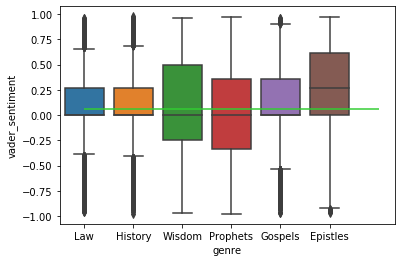

In [12]:
ax = sns.boxplot(x="genre", y="vader_sentiment", data=df)
#ax = sns.swarmplot(x="genre", y="vader_sentiment", data=df, color=".25")
plt.hlines(df['vader_sentiment'].mean(),0,6, color='limegreen')
print("Boxplot of mean sentiment of each genre")

In [13]:
df_book_avg = df.groupby('book')['book','book_no','vader_sentiment'].mean().sort_values(by='book_no')
print("Average sentiment by book")
df_book_avg

Average sentiment by book


,book_no,vader_sentiment
book,,
Genesis,1,0.092322
Exodus,2,0.048060
Leviticus,3,-0.021380
Numbers,4,-0.039762
Deuteronomy,5,0.079937
Joshua,6,0.045335
Judges,7,0.014053
Ruth,8,0.076616
1 Samuel,9,0.033081


In [14]:
#joinging each book into a complete corpus
df_books = pd.DataFrame(df.groupby('book')['text'].apply(list))
df_books.text = df_books.text.apply(prep.text_join)

In [15]:
df_books.head()

,text
book,
1 Chronicles,adam seth enoshkenan mahalalel jaredenoch meth...
1 Corinthians,paul called ' apostle jesus christ god sosthen...
1 John,beginning heard seen eyes beheld hands handled...
1 Kings,king david old stricken years covered clothes ...
1 Peter,peter apostle jesus christ elect sojourners di...


In [16]:
#grouping verses by chapter and applying vader sentiment score to each chapter
df_chap = pd.DataFrame(df.groupby(['book','ch'])['text'].apply(list))
df_chap.text = df_chap.text.apply(prep.text_join)
df_chap['vader_sentiment'] = df_chap.text.apply(lambda txt: sia.polarity_scores(txt)['compound'])

In [17]:
#example of one book grouped by chapter
df_chap.loc['Matthew']

,text,vader_sentiment
ch,,
1,book generation jesus christ son david son abr...,0.8402
2,jesus born bethlehem judaea days herod king be...,0.8979
3,days cometh john baptist preaching wilderness ...,0.9803
4,jesus led spirit wilderness tempted devilfaste...,0.9062
5,seeing multitudes went mountain sat disciples ...,0.9726
6,take heed ye righteousness men seen else ye re...,0.9899
7,judge ye judgedjudgment ye judge ye shall judg...,0.9413
8,come mountain great multitudes followedbehold ...,0.9776
9,entered boat crossed came citybehold brought m...,-0.3182


In [18]:
#removing some additional stopwords and grouping by word frequency
df_books.text = df_books.text.apply(prep.remove_stopwords, args=(['said','thee','ye','thou','thy',"'",'shall','unto'],))
raw_count = pd.Series(" ".join(df_books.text).split()).value_counts()

10 most common words


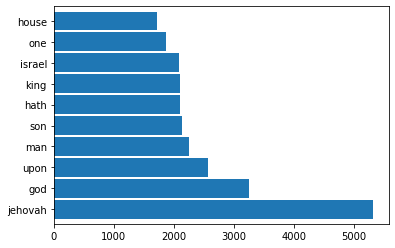

In [19]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
print('10 most common words')

In [20]:
df_gospels = df_books[df_books.index.isin(['John','Mark','Matthew','Luke'])]

In [21]:
df_gospels.text = df_gospels.text.apply(prep.remove_stopwords, args=(['said','thee','ye','thou','thy',"'",'shall','unto','things','say'],))

10 most common words from Gospels


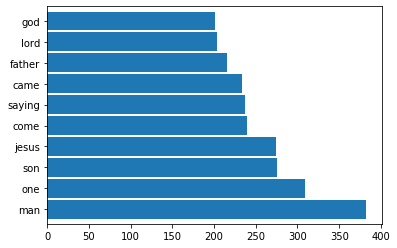

In [22]:
raw_count = pd.Series(" ".join(df_gospels.text).split()).value_counts()
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
print('10 most common words from Gospels')

In [23]:
#assigning sentiment groups based on vader score. 
#Very positive, positive, neutral, negative, and very negative
df['vader'] = round(df.vader_sentiment,1)
df['sentiment_group'] = np.where(df.vader >= .7,'very positive',np.where(df.vader>=.1,'positive',np.where(df.vader == 0,'neutral',np.where(df.vader >= -.6,'negative','very negative'))))

In [24]:
#total verse count for each book
verse_count = df.groupby('book').count()
verse_count.reset_index(inplace=True)
verse_count = verse_count[['book','sentiment_group']]
verse_count.head(2)

,book,sentiment_group
0,1 Chronicles,942
1,1 Corinthians,437


In [25]:
#total verses by book and sentiment group
df_likert = df.groupby(['book','sentiment_group'])['id'].count().reset_index()

In [26]:
df_likert.head(8)

,book,sentiment_group,id
0,1 Chronicles,negative,66
1,1 Chronicles,neutral,645
2,1 Chronicles,positive,149
3,1 Chronicles,very negative,17
4,1 Chronicles,very positive,65
5,1 Corinthians,negative,68
6,1 Corinthians,neutral,140
7,1 Corinthians,positive,145


In [27]:
df_likert_total = pd.merge(df_likert,verse_count,left_on='book',right_on='book')

In [28]:
df_likert_total.head(2)

,book,sentiment_group_x,id,sentiment_group_y
0,1 Chronicles,negative,66,942
1,1 Chronicles,neutral,645,942


In [29]:
#calculating percent of each sentiment group by book
df_likert_total['percent'] = round(df_likert_total.id/df_likert_total.sentiment_group_y,2)

In [30]:
df_likert_total.head(5)

,book,sentiment_group_x,id,sentiment_group_y,percent
0,1 Chronicles,negative,66,942,0.07
1,1 Chronicles,neutral,645,942,0.68
2,1 Chronicles,positive,149,942,0.16
3,1 Chronicles,very negative,17,942,0.02
4,1 Chronicles,very positive,65,942,0.07


In [31]:
#grabbing book # for sorting in Tableau
df_books = df.groupby('book')[['book','book_no']].mean()
df_books.sort_values(by='book_no')

,book_no
book,
Genesis,1
Exodus,2
Leviticus,3
Numbers,4
Deuteronomy,5
Joshua,6
Judges,7
Ruth,8
1 Samuel,9


In [32]:
#final table for tableau viz
#book name, sentiment group, total verses, percent of verse, and book no
df_likert_final = pd.merge(df_likert_total,df_books,left_on='book',right_on='book')
df_likert_final.columns = ['book','sentiment','sentiment_verses','total_verses','percent','book_no']

In [33]:
df_likert_final.head(15)

,book,sentiment,sentiment_verses,total_verses,percent,book_no
0,1 Chronicles,negative,66,942,0.07,13
1,1 Chronicles,neutral,645,942,0.68,13
2,1 Chronicles,positive,149,942,0.16,13
3,1 Chronicles,very negative,17,942,0.02,13
4,1 Chronicles,very positive,65,942,0.07,13
5,1 Corinthians,negative,68,437,0.16,46
6,1 Corinthians,neutral,140,437,0.32,46
7,1 Corinthians,positive,145,437,0.33,46
8,1 Corinthians,very negative,24,437,0.05,46
9,1 Corinthians,very positive,60,437,0.14,46


In [34]:
df_likert_final.percent = np.where(df_likert_final.sentiment == 'negative',df_likert_final.percent * -1,np.where(df_likert_final.sentiment == "very negative",df_likert_final.percent * -1,df_likert_final.percent))

In [42]:
df_likert_final['scripture'] = "Bible"

In [43]:
df_likert_final.head(8)

,book,sentiment,sentiment_verses,total_verses,percent,book_no,scripture
0,1 Chronicles,negative,66,942,-0.07,13,Bible
1,1 Chronicles,neutral,645,942,0.68,13,Bible
2,1 Chronicles,positive,149,942,0.16,13,Bible
3,1 Chronicles,very negative,17,942,-0.02,13,Bible
4,1 Chronicles,very positive,65,942,0.07,13,Bible
5,1 Corinthians,negative,68,437,-0.16,46,Bible
6,1 Corinthians,neutral,140,437,0.32,46,Bible
7,1 Corinthians,positive,145,437,0.33,46,Bible


In [44]:
df_likert_final.to_csv("bible_by_book_likert.csv",index=False)

In [45]:
pd.read_csv('bible_by_book_likert.csv').sort_values(by='book_no')

,book,sentiment,sentiment_verses,total_verses,percent,book_no,scripture
143,Genesis,negative,213,1533,-0.14,1,Bible
144,Genesis,neutral,739,1533,0.48,1,Bible
145,Genesis,positive,401,1533,0.26,1,Bible
146,Genesis,very negative,47,1533,-0.03,1,Bible
147,Genesis,very positive,133,1533,0.09,1,Bible
127,Exodus,very positive,61,1213,0.05,2,Bible
126,Exodus,very negative,42,1213,-0.03,2,Bible
125,Exodus,positive,289,1213,0.24,2,Bible
124,Exodus,neutral,648,1213,0.53,2,Bible
123,Exodus,negative,173,1213,-0.14,2,Bible


<img src="files/old_testament.png">

<img src="files/new_testament.png">